### imports

In [18]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# exploration and initial preprocessing

In [19]:
data = pd.read_csv('train.csv')
data.set_index('id')

Y = data.loc[:,'purchase'] 
X = data.iloc[:, :-1]

X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.8,random_state=23)


print('first glance:')
X_train.head(5)

first glance:


,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,...,Month,device,internet_browser,Region,user_type,Weekend,A,B,C,D
2442,2442,0.0,0.000000,0.0,0.0 minutes,5.0,108.0 minutes,108.000000,0.000000,0.080000,...,May,2.0,chrome_90.1.7,3.0,Returning_Visitor,False,c_13,92.047040,log202,NaN
4138,4138,7.0,188.166667,0.0,0.0 minutes,52.0,1089.642857 minutes,1277.809524,0.003509,0.010234,...,May,2.0,browser_5_v19,6.0,Returning_Visitor,True,c_5,95.347227,log8080,NaN
8935,8935,7.0,133.466667,4.0,46.5 minutes,26.0,1357.833333 minutes,NaN,0.000000,0.018487,...,Nov,3.0,chrome_89,9.0,New_Visitor,True,c_2,87.950930,log202,NaN
3648,3648,4.0,259.000000,1.0,42.0 minutes,18.0,401.968254 minutes,NaN,0.000000,0.017105,...,May,1.0,safari_14,3.0,Returning_Visitor,False,c_3,109.345812,log404,NaN
10110,10110,1.0,153.500000,0.0,0.0 minutes,NaN,1002.847222 minutes,NaN,0.000000,0.009524,...,Nov,2.0,chrome_90.1.7,4.0,Returning_Visitor,False,c_2,117.950076,log200,NaN


In [20]:
print("** types: **")
print(X_train.dtypes)

print('\n** label values: **\n',y_train.value_counts())
print(f'purchased sessions are around {int((y_train.loc[y_train == 1].shape[0] / y_train.shape[0]) * 100)}% of all sessions')

** types: **
id                         int64
num_of_admin_pages       float64
admin_page_duration      float64
num_of_info_pages        float64
info_page_duration        object
num_of_product_pages     float64
product_page_duration     object
total_duration           float64
BounceRates              float64
ExitRates                float64
PageValues               float64
closeness_to_holiday     float64
Month                     object
device                   float64
internet_browser          object
Region                   float64
user_type                 object
Weekend                   object
A                         object
B                        float64
C                         object
D                        float64
dtype: object

** label values: **
 0    1768
1     327
Name: purchase, dtype: int64
purchased sessions are around 15% of all sessions


### page durations

In [21]:
fields = ['info_page_duration', 'product_page_duration']

for field in fields:
    print(field, 'str structure:', X_train[field].value_counts().index[0])
    

    # make sure all durations are in minutes
    print('not minutes count: ', len(X_train.loc[~X_train[field].str.contains('minutes').astype('bool'),(field)]))


    # convert to float `type(d)==str ` handles nan values
    X_train[field] = [float(d.split()[0]) if type(d)==str else np.nan for d in X_train[field]]

print('new types:')
X_train.dtypes[fields]


info_page_duration str structure: 0.0 minutes
not minutes count:  0
product_page_duration str structure: 0.0 minutes
not minutes count:  0
new types:


info_page_duration       float64
product_page_duration    float64
dtype: object

### user type
user type has mainly two values, `New_Visitor` and  `Returning_Visitor`.
We wanted to see if we can map it to a binary feature.
For this, we:
1. made sure that `nan` and `other` are very rare
2. made sure there is no strong correlation between `other` and the label or featrue.

In [22]:
# check values
vc = X_train.user_type.value_counts()
nan_count = X_train.user_type.isnull().sum()
print('original user type values:\n', vc)
print('nan count        :', nan_count)
print('\n`other` categoryh is only ', f"{round(vc['Other'] / X_train.shape[0] * 100, 2)}%", 'of the data')
print('nan values are only ', f"{round(nan_count / X_train.shape[0] * 100, 2)}%", 'of the data')



original user type values:
 Returning_Visitor    1781
New_Visitor           290
Other                  17
Name: user_type, dtype: int64
nan count        : 7

`other` categoryh is only  0.81% of the data
nan values are only  0.33% of the data


<AxesSubplot:>

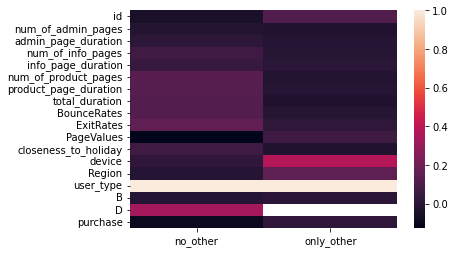

In [23]:
# var to check `other`` corrlations
data_other = X_train.join(y_train)

# var to fill missing values and make user_type binary
data_bin_no_other = data_other.copy()

# map other to 1 and non-otehr to 0
matcher = {'Returning_Visitor': 0, 'New_Visitor': 0, 'Other': 1}                    
data_other.user_type = [matcher.get(u_type, 0) for u_type in X_train.user_type]




matcher.pop('Other')
matcher['Returning_Visitor'] = 1

# map missing values, 'other', and  Returning_Visitor to 1, and New_Visitor to 0
data_bin_no_other.user_type = [matcher.get(u_type, matcher['Returning_Visitor']) for u_type in X_train.user_type] 

# comprae correlations of data without `other`, and data with only `other`
data_other_corr = data_other.corr().user_type
data_bin_no_other_curr = data_bin_no_other.corr().user_type
data_bin_no_other_curr = data_bin_no_other_curr.rename('no_other')
data_other_corr = data_other_corr.rename('only_other')
corr_compare = pd.concat([data_bin_no_other_curr, data_other_corr],  axis=1)
sb.heatmap(corr_compare)


### user_type - conclusion
one interesting correlartion is with `D`, which is mostly missing values. 
At least for now - we shall treat `user type` as binary, only new and returing users

In [24]:
# convert user type to binary
X_train.user_type = data_bin_no_other.user_type
st = str(X_train.user_type.value_counts()).split('\n')
print(st[0], ' (`other` and `nan` values joined here)')
for s in st[1:]: print(s)

del data_bin_no_other, data_other, data_bin_no_other_curr, data_other_corr


1    1805  (`other` and `nan` values joined here)
0     290
Name: user_type, dtype: int64


array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'num_of_admin_pages'}>,
        <AxesSubplot:title={'center':'admin_page_duration'}>,
        <AxesSubplot:title={'center':'num_of_info_pages'}>],
       [<AxesSubplot:title={'center':'info_page_duration'}>,
        <AxesSubplot:title={'center':'num_of_product_pages'}>,
        <AxesSubplot:title={'center':'product_page_duration'}>,
        <AxesSubplot:title={'center':'total_duration'}>],
       [<AxesSubplot:title={'center':'BounceRates'}>,
        <AxesSubplot:title={'center':'ExitRates'}>,
        <AxesSubplot:title={'center':'PageValues'}>,
        <AxesSubplot:title={'center':'closeness_to_holiday'}>],
       [<AxesSubplot:title={'center':'device'}>,
        <AxesSubplot:title={'center':'Region'}>,
        <AxesSubplot:title={'center':'user_type'}>,
        <AxesSubplot:title={'center':'B'}>],
       [<AxesSubplot:title={'center':'D'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype

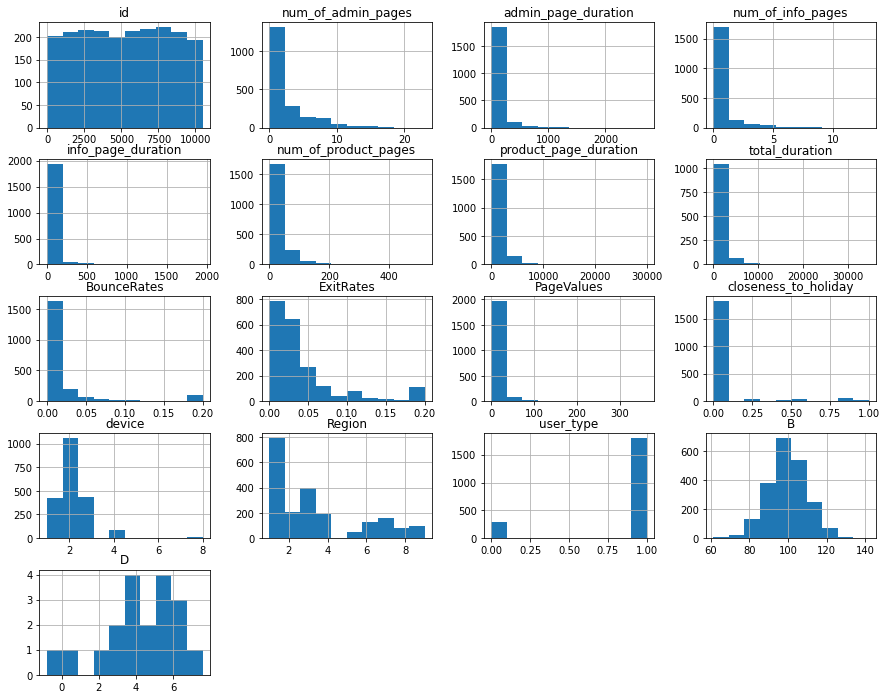

In [25]:
X_train.hist(figsize=(15,12))

<AxesSubplot:>

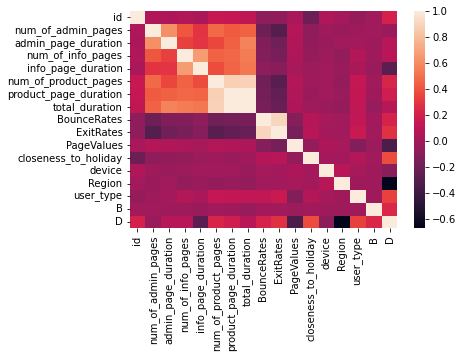

In [26]:
corr = X_train.corr()
sb.heatmap(corr)

## explore D
d's seem to have mostly nan values

we consider remoiving this feature. but first let's see exectly how much data is missing, and how valuable the data is

In [27]:
valid_ds = X_train.loc[~np.isnan(X.D)]
print('only', str((valid_ds.shape[0] / X_train.shape[0]) * 100)[:3], "% of D's have values")

# remove D feature
print("removing D feature")
X_train = X_train.drop(columns=('D'))


only 0.9 % of D's have values
removing D feature


## C column

In [28]:
# X_train.C.value_counts()
# X_train_no_C = X_train.copy()
# X_train_no_C = X_train_no_C.drop(columns=('C'))
X_train = pd.get_dummies(X_train,columns=['C'],drop_first=True)


## weekand

In [29]:
# inital values
X_train.Weekend.value_counts
X_train.Weekend = [1 if w else 0 for w in X_train.Weekend]
X_train.Weekend.value_counts()


0    1588
1     507
Name: Weekend, dtype: int64

## B column

In [30]:
print("B nan count:", X_train.B.isnull().sum())
X_train.B = X_train.B.fillna(X_train.B.mean())
print("B nan count after filling:", X_train.B.isnull().sum())

X_train.head(3)

B nan count: 6
B nan count after filling: 0


,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,...,Region,user_type,Weekend,A,B,C_log202,C_log400,C_log404,C_log8080,C_log_100
2442,2442,0.0,0.000000,0.0,0.0,5.0,108.000000,108.000000,0.000000,0.080000,...,3.0,1,0,c_13,92.047040,1,0,0,0,0
4138,4138,7.0,188.166667,0.0,0.0,52.0,1089.642857,1277.809524,0.003509,0.010234,...,6.0,1,1,c_5,95.347227,0,0,0,1,0
8935,8935,7.0,133.466667,4.0,46.5,26.0,1357.833333,NaN,0.000000,0.018487,...,9.0,0,1,c_2,87.950930,1,0,0,0,0


## internet browser

In [31]:
X_train.internet_browser = X_train.internet_browser.str.replace('\d+', '')
X_train['internet_browser'] = X_train['internet_browser'].astype(str).str.extract(r'([A-Za-z]+(?: [A-Za-z]+)*)')

X_train.internet_browser.value_counts()

C:\Users\itayz\AppData\Local\Temp\ipykernel_8308\2460500965.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  X_train.internet_browser = X_train.internet_browser.str.replace('\d+', '')


chrome     1286
safari      380
browser     192
nan         123
edge        114
Name: internet_browser, dtype: int64

In [35]:
print("browser nan count:", X_train.internet_browser.isna().sum())
print("no need to fill!")
X_train.internet_browser[X_train.internet_browser == 'nan']

browser nan count: 0
no need to fill!


8675    nan
555     nan
8845    nan
264     nan
930     nan
       ... 
9798    nan
2080    nan
9485    nan
4499    nan
3129    nan
Name: internet_browser, Length: 123, dtype: object

In [16]:
X_train = pd.get_dummies(X_train,columns=['internet_browser'],drop_first=True)

## month

In [ ]:
X_train.Month.value_counts().head(12)


May     587
Nov     502
Mar     308
Dec     296
Oct      97
Aug      86
Sep      75
Jul      74
June     34
Feb      30
Name: Month, dtype: int64

In [3]:
Month = {'JAN':1, 'Feb':2, 'Mar':3, 'APR':4, 'May':5, 'June':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}
X_train.Month = X_train.Month.map(Month)
X_train.Month.head(10)


NameError: name 'X_train' is not defined

##### First, we will try to convert the Month to dummy variables by dividing the year into quarters:
First quarter: January - March <br>
Second quarter: April - June <br>
Third quarter: July - Septemper <br>
Fourth Quarter: October - December <br>

In [ ]:
X_train.Month = [1 if m else 0 for m in X_train.Weekend]


In [151]:
q = {'JAN':1, 'Feb':1, 'Mar':1, 'APR':2, 'May':2, 'June':2, 'Jul':3, 'Aug':3, 'Sep':3, 'Oct':4, 'Nov':4, 'Dec':4}
X_train.Month = X_train.Month.map(q)
X_train = pd.get_dummies(X_train,columns=['Month'],drop_first=True)
X_train.Month.head(10)

AttributeError: 'DataFrame' object has no attribute 'Month'